In [3]:
#Files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import glob

#DATA
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

#CNN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Convolution2D,MaxPooling2D,Flatten,Dense
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy

#VIS
from keras.utils.vis_utils import plot_model

In [4]:
def _prepareData(path): 
    '''
    parameters: path(STR) of the directory and flag(INT) to know if we prepare data of training or testing
    return: (LIST) of images of the dataset and the (LIST) of labels
    
    For training:
    -Read images of every directory and extract all images
    -Resize to (128,128,3)
    -Read the directory name and asign as a class
    '''
    imgsList = []
    labels = []
    for directory in sorted(glob.glob(os.path.join(path, '*')), key = lambda k: k.split("/")[-1]):
            for imgs in glob.glob(os.path.join(directory,'*.jpg')):
                img_cv = cv2.imread(imgs)
                img_cv_r = cv2.resize(img_cv,(128,128))
                imgsList.append(img_cv_r)
                labels.append(int(directory.split("/")[-1].replace('c','')))
    

    X_Train, X_Test, Y_Train, Y_Test =  train_test_split(imgsList,labels, test_size = 0.2)
    Y_Train = tf.keras.utils.to_categorical(Y_Train, num_classes=10)
    Y_Test = tf.keras.utils.to_categorical(Y_Test, num_classes=10)

    return np.array(X_Train), np.array(X_Test), Y_Train, Y_Test

In [5]:
#Paths
pathTrain_Images = "/Users/bxia/Desktop/scu/DeepLearning_Fall2020/project/imgs/train"
pathPropagate_Images =  "/Users/bxia/Desktop/scu/DeepLearning_Fall2020/project/imgs/test"

#List of Images for Train and Test
X_Train, X_Test, Y_Train, Y_Test = _prepareData(pathTrain_Images)

print("Size X_Train: {}, Size Y_Train: {}".format(len(X_Train),len(Y_Train)))
print("Size X_Test: {}, Size Y_Test: {}".format(len(X_Test),len(Y_Test)))

Size X_Train: 17939, Size Y_Train: 17939
Size X_Test: 4485, Size Y_Test: 4485


## Check Data Intergrity

### Classes: 
c0: safe driving <br> c1: texting - right <br>c2: talking on the phone - right <br> c3: texting - left <br> c4: talking on the phone - left <br> c5: operating the radio <br>c6: drinking <br> c7: reaching behind <br>c8: hair and makeup <br>c9: talking to passenger

There are 17939 images in the training set.
The shape of image is (128, 128, 3)


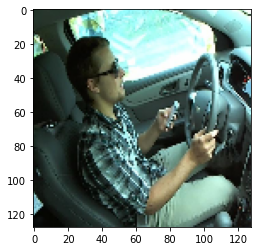

Class: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


In [6]:
print('There are', len(X_Train), 'images in the training set.')
print('The shape of image is', X_Train[202].shape)
im = X_Train[202]
RGB_im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_im)
plt.show()
print("Class: {}".format(Y_Train[202]))

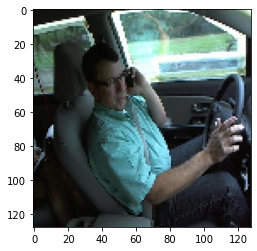

Class: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


In [7]:
im = X_Train[388]
RGB_im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_im)
plt.show()
print("Class: {}".format(Y_Train[388]))

## Check Data Distribution

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

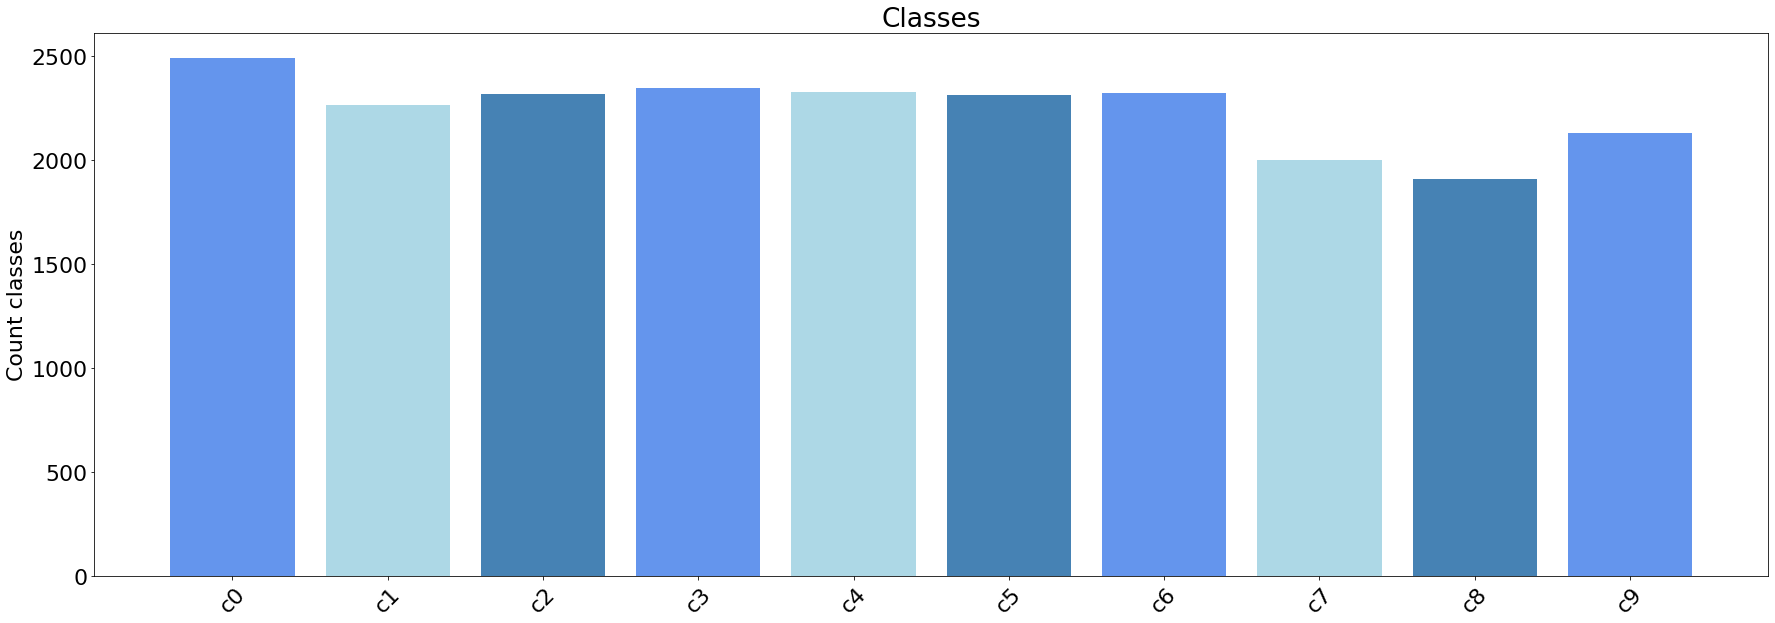

In [8]:
data_file = pd.read_csv("/Users/bxia/Desktop/scu/DeepLearning_Fall2020/project/driver_imgs_list.csv")
data_classes = data_file.loc[:,['classname','img']].groupby(by='classname').count().reset_index()

data_x = list(pd.unique(data_file['classname']))
data_y =list(data_classes['img'])

# Parámetros de ploteo (Se va a generar un plot diferente para cada Clase)
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(30,10))
plt.bar(data_x, data_y, color=['cornflowerblue', 'lightblue', 'steelblue'])  
plt.ylabel('Count classes')
plt.title('Classes')
plt.xticks(rotation=45)

#### The training dataset is well balanced to a great extent and hence we need not do any downsampling of the data.

## Create Architecture

In [12]:
model = keras.models.Sequential()

model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
    
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1024, activation='relu'))
model.add(keras.layers.Dense(1024, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))
model.save('/tmp/model')
#model.compute_output_shape(input_shape=(256,8,8,1))

INFO:tensorflow:Assets written to: /tmp/model/assets


In [14]:
tf.random.set_seed(1)
#model.build(input_shape=(None,128,128,3))
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.CategoricalCrossentropy(from_logits = False), metrics = ['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 61, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 12, 12, 64)       

## Train Model

In [15]:
history = model.fit(x = X_Train, y=Y_Train,epochs = 10, batch_size = 500, verbose = 1,validation_split=0.2)

Epoch 1/10
29/29 [==============================] - 161s 6s/step - loss: 4.0990 - accuracy: 0.1681 - val_loss: 1.9286 - val_accuracy: 0.3551
Epoch 2/10
29/29 [==============================] - 140s 5s/step - loss: 1.5281 - accuracy: 0.4739 - val_loss: 1.0862 - val_accuracy: 0.6391
Epoch 3/10
29/29 [==============================] - 102s 4s/step - loss: 0.7202 - accuracy: 0.7611 - val_loss: 0.4899 - val_accuracy: 0.8514
Epoch 4/10
29/29 [==============================] - 91s 3s/step - loss: 0.3608 - accuracy: 0.8870 - val_loss: 0.2923 - val_accuracy: 0.9144
Epoch 5/10
29/29 [==============================] - 91s 3s/step - loss: 0.1955 - accuracy: 0.9435 - val_loss: 0.1953 - val_accuracy: 0.9459
Epoch 6/10
29/29 [==============================] - 93s 3s/step - loss: 0.1242 - accuracy: 0.9640 - val_loss: 0.1631 - val_accuracy: 0.9529
Epoch 7/10
29/29 [==============================] - 94s 3s/step - loss: 0.0884 - accuracy: 0.9749 - val_loss: 0.1933 - val_accuracy: 0.9431
Epoch 8/10
29/29 

## Evaluate Model with Test Data

In [16]:
test_loss, test_acc = model.evaluate(X_Test, Y_Test, verbose = 1)

141/141 [==============================] - 8s 55ms/step - loss: 0.1330 - accuracy: 0.9619


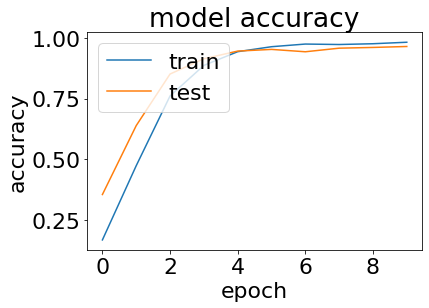

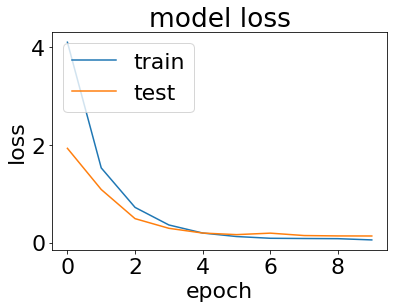

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
#plt.ylim([0.9,1])
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.ylim([0,.4])
plt.legend(['train','test'], loc='upper left')
plt.show()

### Save Weights

In [18]:
model_json = model.to_json()
model.save_weights('Train_weights_1.h5',overwrite = True)

In [19]:
model.load_weights('Train_weights_1.h5')

## Show Architecture Distribution

In [20]:
keras.utils.plot_model(model,"model.png",show_shapes = True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


## Model 1

## Predict Test Data and Create Submission File

In [21]:
df = pd.DataFrame({'img':[],'c0':[], 'c1':[],'c2':[], 'c3':[], 'c4':[],'c5':[], 'c6':[], 'c7':[], 'c8':[], 'c9':[]})
def _submission(pathPropagate_Images,df):
    for imgs in glob.glob(os.path.join(pathPropagate_Images,'*.jpg')):
        img_cv = cv2.imread(imgs)
        img_cv_r = cv2.resize(img_cv,(128,128))
        img_cv_predict = np.reshape(img_cv_r,[1,128,128,3])
        arr_predict = model.predict(img_cv_predict,batch_size = 1)
        #print(imgs.split('/')[-1])
        df = df.append(
            {
                'img':imgs.split('/')[-1],
                'c0':round(arr_predict[0][0],2), 
                'c1':round(arr_predict[0][1],2),
                'c2':round(arr_predict[0][2],2),
                'c3':round(arr_predict[0][3],2),
                'c4':round(arr_predict[0][4],2),
                'c5':round(arr_predict[0][5],2),
                'c6':round(arr_predict[0][6],2),
                'c7':round(arr_predict[0][7],2),
                'c8':round(arr_predict[0][8],2),
                'c9':round(arr_predict[0][9],2)
            },
            ignore_index=True
        )
    return df

In [22]:
img_cv = cv2.imread("/Users/bxia/Desktop/scu/DeepLearning_Fall2020/project/imgs/test/img_41.jpg")
img_cv_r = cv2.resize(img_cv,(128,128))
img_cv_predict = np.reshape(img_cv_r,[1,128,128,3])
arr_predict = model.predict(img_cv_predict,batch_size = 1)

print(arr_predict)
print(round(arr_predict[0][9],2))


[[5.0612187e-01 1.5886656e-03 4.8105416e-05 4.7245714e-01 6.8073764e-06
  9.1117444e-03 3.2656154e-04 8.8582290e-03 8.9026272e-04 5.9058575e-04]]
0.0


In [18]:
pathPropagate_Images = "/Users/bxia/Desktop/scu/DeepLearning_Fall2020/project/imgs/test"
df = _submission(pathPropagate_Images,df)

In [19]:
print(df.shape)
df.head(50)

(79726, 11)


img    c0    c1    c2    c3    c4    c5    c6    c7    c8    c9
0   img_60161.jpg  0.00  0.00  0.00  0.00  0.00  1.00  0.00  0.00  0.00  0.00
1   img_94786.jpg  0.00  0.00  0.00  0.00  0.00  0.00  0.95  0.00  0.05  0.00
2   img_85853.jpg  0.00  0.35  0.00  0.00  0.01  0.00  0.20  0.15  0.00  0.29
3   img_36327.jpg  0.00  0.00  0.00  0.00  0.72  0.00  0.12  0.16  0.00  0.00
4   img_39014.jpg  0.96  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.04
5   img_84595.jpg  0.01  0.00  0.04  0.00  0.68  0.01  0.03  0.00  0.00  0.22
6   img_57915.jpg  0.00  0.00  0.02  0.17  0.00  0.75  0.00  0.00  0.00  0.07
7   img_37039.jpg  0.00  0.00  0.00  0.00  0.00  1.00  0.00  0.00  0.00  0.00
8   img_11940.jpg  0.00  0.00  0.00  0.00  0.00  0.00  1.00  0.00  0.00  0.00
9   img_20545.jpg  0.23  0.00  0.05  0.00  0.00  0.04  0.00  0.00  0.00  0.67
10  img_66510.jpg  0.00  0.00  0.00  0.00  0.00  0.00  1.00  0.00  0.00  0.00
11  img_10486.jpg  0.02  0.97  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.01
12  img_79430.jpg  0.00  0.00  0.00  1.00  0.00  0.00  0.00  0.00  0.00  0.00
13  img_48835.jpg  0.00  0.00  0.00  0.00  0.00  1.00  0.00  0.00  0.00  0.00
14  img_30756.jpg  0.00  0.00  0.00  1.00  0.00  0.00  0.00  0.00  0.00  0.00
15  img_21883.jpg  0.00  0.00  0.00  0.00  0.01  0.13  0.00  0.00  0.00  0.86
16  img_96191.jpg  0.00  0.09  0.00  0.00  0.04  0.85  0.01  0.00  0.00  0.00
17  img_24723.jpg  0.00  0.00  0.00  0.00  0.00  0.00  0.97  0.03  0.00  0.00
18  img_62776.jpg  0.00  0.00  0.00  0.00  0.00  0.00  1.00  0.00  0.00  0.00
19  img_65019.jpg  0.02  0.00  0.00  0.95  0.00  0.02  0.00  0.00  0.00  0.00
20  img_43960.jpg  0.00  0.00  0.00  0.82  0.03  0.00  0.08  0.03  0.04  0.00
21  img_86382.jpg  0.00  0.00  0.98  0.00  0.00  0.00  0.02  0.00  0.00  0.00
22  img_72565.jpg  0.00  0.88  0.02  0.00  0.00  0.00  0.00  0.00  0.10  0.00
23  img_22352.jpg  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.58  0.42
24  img_74114.jpg  0.00  0.13  0.00  0.00  0.00  0.00  0.87  0.00  0.00  0.00
25   img_5811.jpg  0.00  1.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00
26  img_14838.jpg  0.01  0.00  0.05  0.88  0.03  0.01  0.00  0.00  0.00  0.02
27  img_32141.jpg  0.00  0.00  0.00  0.00  0.00  0.00  1.00  0.00  0.00  0.00
28  img_12291.jpg  0.00  0.00  0.00  1.00  0.00  0.00  0.00  0.00  0.00  0.00
29  img_63468.jpg  0.00  0.26  0.02  0.00  0.00  0.00  0.00  0.00  0.69  0.03
30    img_329.jpg  0.00  0.00  0.00  0.00  0.00  0.00  1.00  0.00  0.00  0.00
31  img_32627.jpg  0.00  0.00  0.00  0.00  0.02  0.98  0.00  0.00  0.00  0.00
32  img_80095.jpg  0.00  0.00  0.00  0.00  0.00  0.00  1.00  0.00  0.00  0.00
33  img_22434.jpg  0.99  0.00  0.00  0.00  0.01  0.00  0.00  0.00  0.00  0.00
34  img_15298.jpg  0.00  0.00  0.00  0.00  0.00  0.00  0.00  1.00  0.00  0.00
35  img_35148.jpg  0.04  0.00  0.00  0.00  0.96  0.00  0.00  0.00  0.00  0.00
36  img_90286.jpg  0.00  0.00  0.00  0.00  0.00  0.00  1.00  0.00  0.00  0.00
37  img_55864.jpg  0.13  0.01  0.00  0.21  0.09  0.00  0.00  0.00  0.10  0.47
38  img_13831.jpg  0.00  0.00  0.00  0.00  0.00  1.00  0.00  0.00  0.00  0.00
39   img_2818.jpg  0.00  0.00  0.00  0.00  0.00  0.00  0.02  0.98  0.00  0.00
40  img_98802.jpg  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.97  0.03
41  img_72203.jpg  0.00  0.00  0.75  0.00  0.00  0.00  0.25  0.00  0.00  0.00
42  img_91198.jpg  0.00  0.00  0.00  0.00  0.00  0.00  1.00  0.00  0.00  0.00
43  img_34256.jpg  0.38  0.51  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.12
44  img_87922.jpg  0.06  0.00  0.00  0.00  0.00  0.00  0.94  0.00  0.00  0.00
45  img_24045.jpg  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  1.00  0.00
46  img_61519.jpg  0.00  0.00  0.00  0.00  0.00  1.00  0.00  0.00  0.00  0.00
47  img_79356.jpg  0.00  0.03  0.00  0.00  0.00  0.00  0.00  0.00  0.05  0.92
48  img_93957.jpg  0.07  0.00  0.00  0.00  0.04  0.00  0.89  0.00  0.00  0.00
49   img_7960.jpg  0.32  0.00  0.00  0.00  0.67  0.01  0.00  0.00  0.00  0.00

In [20]:
df.to_csv('submission_file.csv',index = False)